In [2]:
import pandas as pd
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import anndata

In [3]:
from matplotlib import rc

labelsize = 6
linewidth = 0.6
rc('lines', linewidth=linewidth)
rc('axes', labelsize=labelsize, linewidth=linewidth)
rc('xtick', labelsize=labelsize)
rc('ytick', labelsize=labelsize)
rc('xtick.major', width=linewidth)
rc('ytick.major', width=linewidth)
rc('xtick.minor', width=linewidth-0.2)
rc('ytick.minor', width=linewidth-0.2)
rc('patch', linewidth=linewidth)

major_type_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/major_type.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()
sub_type_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/sub_type.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()
major_region_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/major_region.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()
sub_region_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/sub_region.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()


In [4]:
oddsratio_cutoff = 1.8
lgp_cutoff = 10
motif_enrichment_dir = '/home/hanliu/project/mouse_rostral_brain/study/ClustersEnsemble/HPFSubtypeEnsemble/MotifEnrichment/'
tf_class_level = 'SubFamily'

In [5]:
group_name = 'GeneCluster'

In [6]:
# Parameters
oddsratio_cutoff = 1.8
lgp_cutoff = 3
motif_enrichment_dir = "/home/hanliu/project/mouse_rostral_brain/study/ClustersEnsemble/HPFSubtypeEnsemble/MotifEnrichment"
tf_class_level = "SubFamily"


## Gene and motif metadata

In [7]:
motif_meta_with_cluster = pd.read_csv(
    '/home/hanliu/project/mouse_rostral_brain/study/MotifClustering/JASPAR2020_CORE_vertebrates_non-redundant.mouse_genes.with_motif_group.199.csv',
    index_col='motif_uid'
)
gene_meta = pd.read_csv('/home/hanliu/ref/mouse/gencode/vm22/gencode.vM22.annotation.gene.flat.tsv.gz',
                        sep='\t', index_col='gene_id')
tf_class = pd.read_csv('/home/hanliu/ref/TFGene/TFClass/TFClass.with_mouse_gene_id.csv')
tf_class.head()

,uid,GeneRawName,SuperClass,Class,Family,SubFamily,EnsemblID
0,1.1.1.1.1,c-Jun,Basic domains,Basic leucine zipper factors (bZIP),Jun-related,Jun,ENSMUSG00000052684
1,1.1.1.1.2,JunB,Basic domains,Basic leucine zipper factors (bZIP),Jun-related,Jun,"ENSMUSG00000052837,ENSMUSG00000052926"
2,1.1.1.1.3,JunD,Basic domains,Basic leucine zipper factors (bZIP),Jun-related,Jun,ENSMUSG00000071076
3,1.1.1.2.1,NFE2,Basic domains,Basic leucine zipper factors (bZIP),Jun-related,NFE2,ENSMUSG00000058794
4,1.1.1.2.2,NFE2L1,Basic domains,Basic leucine zipper factors (bZIP),Jun-related,NFE2,ENSMUSG00000038615


In [8]:
tf_class[tf_class['Family'].apply(lambda i: 'TB' in i)]

,uid,GeneRawName,SuperClass,Class,Family,SubFamily,EnsemblID
1396,6.5.3.0.1,TBX1,Immunoglobulin fold,T-Box factors,TBX1-related,NaN,ENSMUSG00000009097
1397,6.5.3.0.2,TBX10,Immunoglobulin fold,T-Box factors,TBX1-related,NaN,ENSMUSG00000037477
1398,6.5.3.0.3,TBX15,Immunoglobulin fold,T-Box factors,TBX1-related,NaN,ENSMUSG00000027868
1399,6.5.3.0.4,TBX18,Immunoglobulin fold,T-Box factors,TBX1-related,NaN,ENSMUSG00000032419
1400,6.5.3.0.5,TBX20,Immunoglobulin fold,T-Box factors,TBX1-related,NaN,ENSMUSG00000031965
1401,6.5.3.0.6,TBX22,Immunoglobulin fold,T-Box factors,TBX1-related,NaN,ENSMUSG00000031241
1402,6.5.4.0.1,TBX2,Immunoglobulin fold,T-Box factors,TBX2-related,NaN,ENSMUSG00000000093
1403,6.5.4.0.2,TBX3,Immunoglobulin fold,T-Box factors,TBX2-related,NaN,ENSMUSG00000018604
1404,6.5.4.0.3,TBX4,Immunoglobulin fold,T-Box factors,TBX2-related,NaN,ENSMUSG00000000094
1405,6.5.4.0.4,TBX5,Immunoglobulin fold,T-Box factors,TBX2-related,NaN,ENSMUSG00000018263


In [9]:
levels = ['SuperClass', 'Class', 'Family', 'SubFamily']
for level in levels:
    gene_to_tf_class = {}
    for _, row in tf_class.iterrows():
        if isinstance(row['EnsemblID'], float):
            continue
        for g in row['EnsemblID'].split(','):
            gene_to_tf_class[g] = row[level]
    motif_meta_with_cluster[level] = motif_meta_with_cluster['gene_ids'].map(
        lambda i: gene_to_tf_class[i.split('.')[0]] if i.split('.')[0] in gene_to_tf_class else '')


## Motif Results

In [10]:
motif_results = list(pathlib.Path(motif_enrichment_dir).glob('**/*.motif_enrichment.msg'))
motif_results = [i for i in motif_results if not i.name.startswith('Cell')]
motif_results = pd.concat([pd.read_msgpack(path) for path in motif_results])
motif_results.index.name = 'MotifID'
motif_results.reset_index(inplace=True)
motif_results = pd.concat([motif_results, 
           motif_meta_with_cluster.loc[motif_results['MotifID']].reset_index(drop=True)], axis=1)

motif_results = motif_results.loc[:, ~motif_results.columns.duplicated()]

filtered_results = motif_results[(motif_results['oddsratio'] > oddsratio_cutoff) & 
                              (motif_results['-lgp'] > lgp_cutoff)].copy()


/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
# for each motif class in each group, select most significant ones
use_motif_for_clase_group = motif_results.groupby([tf_class_level, group_name]).apply(
    lambda i: i.sort_values('-lgp', ascending=False)['MotifID'].iloc[0])

In [12]:
# keep one motif for each group and each motif class
use_results = motif_results.set_index([group_name, 'MotifID']).loc[[
    tuple(row.tolist())
    for _, row in use_motif_for_clase_group.reset_index().iloc[:, 1:].iterrows()
]].reset_index()
use_results = use_results[use_results[tf_class_level].fillna('') != ''].copy()

assert (use_results.groupby([tf_class_level, group_name]).apply(lambda i: i.shape[0]) != 1).sum() == 0

In [13]:
use_results.to_msgpack(f'{motif_enrichment_dir}/MotifEnrichment.agg.one_motif_per_class.msg')

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  """Entry point for launching an IPython kernel.


In [14]:
# only keep motif class that has sig hits
sig_motif_class = filtered_results[tf_class_level].unique()
use_results = use_results[use_results[tf_class_level].isin(sig_motif_class)].copy()

In [15]:
motif_class_order = sorted([i for i in filtered_results[tf_class_level].dropna().unique() if i != ''])
cluster_order = sorted(use_results[group_name].unique(), key=lambda i: int(i))

In [16]:
use_results = use_results[use_results[tf_class_level].isin(motif_class_order)]
use_results['x'] = use_results[tf_class_level].apply(lambda i: motif_class_order.index(i))
use_results['y'] = use_results[group_name].apply(lambda i: cluster_order.index(i))
pass_filter_pairs = filtered_results.set_index(['MotifID', group_name]).index
use_results['sig'] = use_results.apply(lambda i: (i['MotifID'], i[group_name]) in pass_filter_pairs, axis=1)
# sync filter to region tfs
pass_filter_pairs = filtered_results[(filtered_results['-lgp'] > lgp_cutoff) & 
                                     (filtered_results['oddsratio'] > oddsratio_cutoff)].set_index(['MotifID', group_name]).index
use_results['sig'] = use_results.apply(lambda i: (i['MotifID'], i[group_name]) in pass_filter_pairs, axis=1)


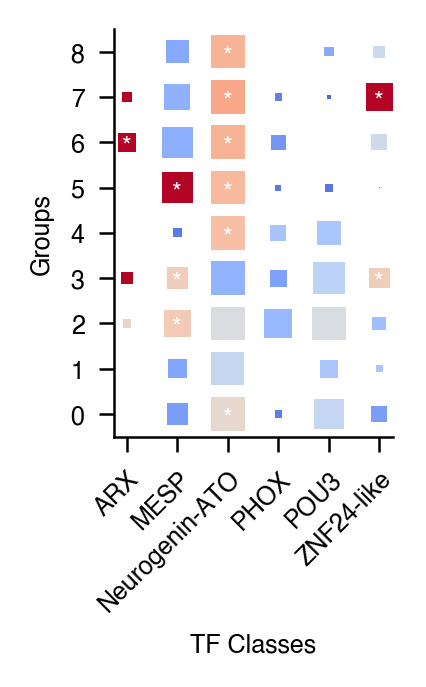

In [17]:
n_col = len(motif_class_order)
n_row = len(cluster_order)

fig, ax = plt.subplots(figsize=(n_col * 0.2, n_row * 0.2), dpi=300)
sns.scatterplot(ax=ax, data=use_results, x='x', y='y', 
                hue='oddsratio', hue_norm=(1, 2.5), palette='coolwarm', marker='s',
                size='-lgp', size_norm=(0, 10), sizes=(0, 65), linewidth=0, clip_on=False)

for _, row in use_results[use_results['sig']].iterrows():
    ax.text(row['x'], row['y']-0.1, '*', ha='center', va='center', fontsize=labelsize, c='white')

ax.set(xticks=range(n_col), xticklabels=[i[:20] for i in motif_class_order],
       yticks=range(n_row), yticklabels=cluster_order, ylim=(-0.5, n_row - .5), 
       xlabel='TF Classes', ylabel='Groups')

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
sns.despine(ax=ax)
ax.legend_.set_visible(False)

In [18]:
fig.savefig(f'{motif_enrichment_dir}/MotifEnrichment.dotmap.pdf', bbox_inches='tight')

## Check if the TF has motif enrichment in matched group

In [20]:
gene_clusters = anndata.read_h5ad('GeneClustering.h5ad').obs['leiden']
records = []
for gene_cluster, sub_df in filtered_results.groupby('GeneCluster'):
    this_genes = gene_clusters[gene_clusters == gene_cluster]
    # print(this_genes)
    has_matched_records = sub_df['gene_ids'].apply(lambda i: any([(g in this_genes) for g in i.split(',')]))
    if has_matched_records.sum():
        print(sub_df[has_matched_records]['gene_names'])

554    Pou3f1
Name: gene_names, dtype: object


In [21]:
filtered_results[filtered_results['SubFamily']=='ZNF24-like']

,MotifID,oddsratio,p_value,adj_p,-lgp,tp,tn,fp,fn,tp_rate,...,DMRType,motif_name,motif_genes,gene_ids,gene_names,motif_group,SuperClass,Class,Family,SubFamily
853,MA1124.1,1.879115,1.849210e-05,1.955268e-04,3.708794,56.0,11865.0,866.0,344787.0,0.004698,...,Hypo,ZNF24,ZNF24,ENSMUSG00000051469.14,Zfp24,MotifGroup176,Zinc-coordinating DNA-binding domains,C2H2 zinc finger factors,More than 3 adjacent zinc fingers,ZNF24-like
1794,MA1124.1,2.619451,7.633724e-09,2.386369e-07,6.622262,49.0,7486.0,862.0,344962.0,0.006503,...,Hypo,ZNF24,ZNF24,ENSMUSG00000051469.14,Zfp24,MotifGroup176,Zinc-coordinating DNA-binding domains,C2H2 zinc finger factors,More than 3 adjacent zinc fingers,ZNF24-like
